# Pytorch - FasterRCNN Train
In this notebook I used both Internet access and GPU enabled
* FasterRCNN with Resnet 50 backbone
* Enabled Albumentation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#from tqdm import tqdm_notebook as tqdm
#from tqdm import tqdm 
from tqdm.notebook import tqdm as tqdm

import cv2
import os
import re

import random

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

In [2]:
INPUT_DATA = "../input/global-wheat-detection/"
TRAIN_DIR = os.path.join(INPUT_DATA, "train")
TEST_DIR = os.path.join(INPUT_DATA, "test")

In [3]:
df = pd.read_csv(os.path.join(INPUT_DATA, "train.csv"))
df.head(5)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
## Shape of Dataframe
print(f"Shape of train DataFrame: {df.shape}")
##Unique Images 
print(f'Unique Images in train DataFrame: {len(df["image_id"].value_counts())}')

Shape of train DataFrame: (147793, 5)
Unique Images in train DataFrame: 3373


In [5]:
## Extract x,y,w,h from bbox
import ast
def extract_bbox(DataFrame):
    DataFrame["x"] = [np.float(ast.literal_eval(i)[0]) for i in DataFrame["bbox"]]
    DataFrame["y"]=  [np.float(ast.literal_eval(i)[1]) for i in DataFrame["bbox"]]
    DataFrame["w"] = [np.float(ast.literal_eval(i)[2]) for i in DataFrame["bbox"]]
    DataFrame["h"] = [np.float(ast.literal_eval(i)[3]) for i in DataFrame["bbox"]]

In [6]:
extract_bbox(df)
df.head()

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


## Train Valid Split

In [7]:
train_ratio = 0.8
images_id = df["image_id"].unique()
train_ids = images_id[:int(len(images_id)*train_ratio)]
valid_ids = images_id[int(len(images_id)*train_ratio):]

print(f"Total Images Number: {len(images_id)}")
print(f"Number of training images: {len(train_ids)}")
print(f"Number of Valid images: {len(valid_ids)}")

Total Images Number: 3373
Number of training images: 2698
Number of Valid images: 675


In [8]:
train_df = df[df["image_id"].isin(train_ids)]
valid_df = df[df["image_id"].isin(valid_ids)]

print(f"Shape of train_df: {train_df.shape}")
print(f"Shape of valid_df: {valid_df.shape}")

Shape of train_df: (122577, 9)
Shape of valid_df: (25216, 9)


In [9]:
# Data Transform - Albumentation
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [10]:
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        super().__init__()
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = dataframe["image_id"].unique()
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        details = self.dataframe[self.dataframe["image_id"]==image_id]
        img_path = os.path.join(TRAIN_DIR, image_id)+".jpg"
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Row of Dataframe of a particular index.
        boxes = details[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        #To find area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        #COnvert it into tensor dataType
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((details.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((details.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx) ### <------------ New change list has been removed
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            
            sample = self.transform(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.long)
        
        return image, target     #, image_id
    
    def __len__(self) -> int:
        return len(self.image_ids)

### Load DataSets

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
train_dataset = WheatDataset(train_df, TRAIN_DIR, get_train_transform())
valid_dataset = WheatDataset(valid_df, TRAIN_DIR, get_valid_transform())

print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of test_dataset: {len(valid_dataset)}")

Length of train_dataset: 2698
Length of test_dataset: 675


In [13]:
##DataLoader
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

### Visualize Images

In [14]:
#PLot images
def plot_images(n_num, random_selection=True):
    '''Function to visualize N Number of images'''
    if random_selection:
        index = random.sample(range(0, len(train_df["image_id"].unique())-1), n_num)
    else:
        index = range(0, n_num)
    plt.figure(figsize=(15,15))
    fig_no = 1
    
    for i in index:
        images, targets = train_dataset.__getitem__(i)
        sample = np.array(np.transpose(images, (1,2,0)))
        boxes = targets["boxes"].numpy().astype(np.int32)
    
        #Plot figure/image

        for box in boxes:
            cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(255,223,0), 2)
        plt.subplot(n_num/2, n_num/2, fig_no)
        plt.imshow(sample)
        fig_no+=1

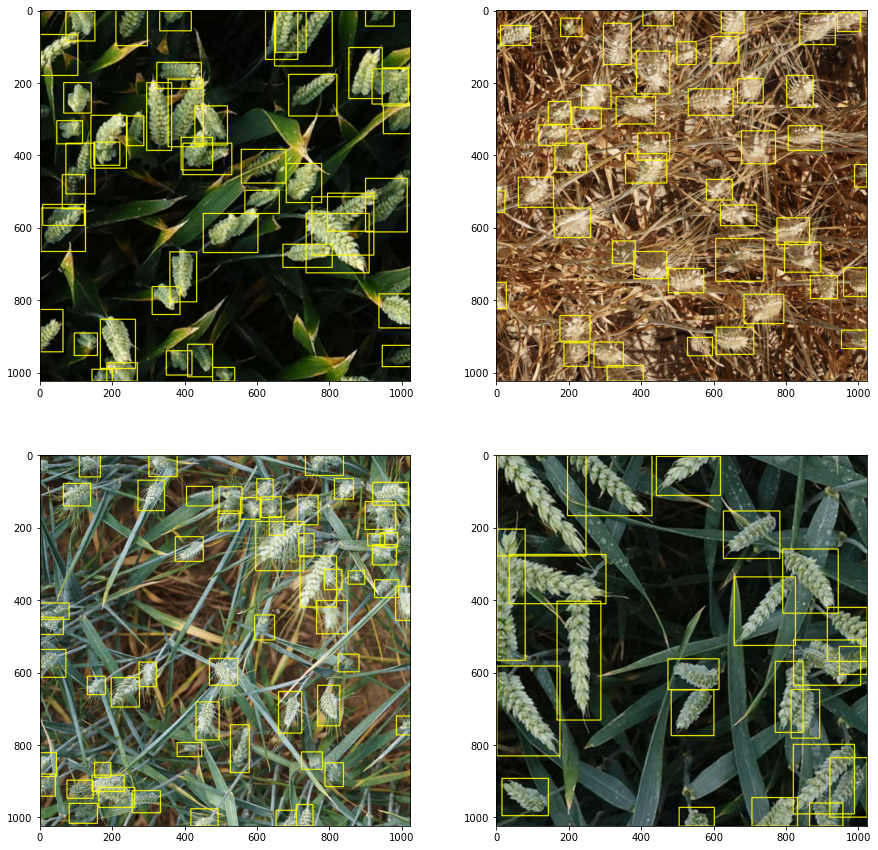

In [15]:
plot_images(4)

## Create Model

In [16]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [17]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [18]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 8

In [20]:
#from engine import evaluate
import time

itr=1

total_train_loss = []
total_valid_loss = []

losses_value = 0
for epoch in range(num_epochs):
  
    start_time = time.time()
    train_loss = []
    model.train()
    
    #<-----------Training Loop---------------------------->
    pbar = tqdm(train_data_loader, desc = 'description')
    for images, targets in pbar:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        losses_value = losses.item()
        train_loss.append(losses_value)        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, loss: {losses_value}")
        itr+=1

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    
    
    #<---------------Validation Loop---------------------->
    with torch.no_grad():
        valid_loss = []

        for images, targets in valid_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # If you need validation losses
            model.train()
            # Calculate validation losses
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            valid_loss.append(loss_value)
            
    epoch_valid_loss = np.mean(valid_loss)
    total_valid_loss.append(epoch_valid_loss)
    
    print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time},\
    Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")    

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)



Epoch Completed: 1/8, Time: 367.34607195854187,    Train Loss: 0.7677194801484339, Valid Loss: 0.7014022139941944



Epoch Completed: 2/8, Time: 363.85819602012634,    Train Loss: 0.6692107554370835, Valid Loss: 0.6789331246824826



Epoch Completed: 3/8, Time: 364.1155607700348,    Train Loss: 0.6459853096297506, Valid Loss: 0.6951159961083356



Epoch Completed: 4/8, Time: 367.8949627876282,    Train Loss: 0.6314911802668544, Valid Loss: 0.6540898046072792



Epoch Completed: 5/8, Time: 370.51387310028076,    Train Loss: 0.6171748432711032, Valid Loss: 0.6443148672580719



Epoch Completed: 6/8, Time: 374.639666557312,    Train Loss: 0.6090382999746051, Valid Loss: 0.6271646804669324



Epoch Completed: 7/8, Time: 374.6648852825165,    Train Loss: 0.6023027585631997, Valid Loss: 0.6288074675728293



Epoch Completed: 8/8, Time: 375.4861316680908,    Train Loss: 0.5940140127782991, Valid Loss: 0.6274760049932143


## Plot Train vs. Valid Losses

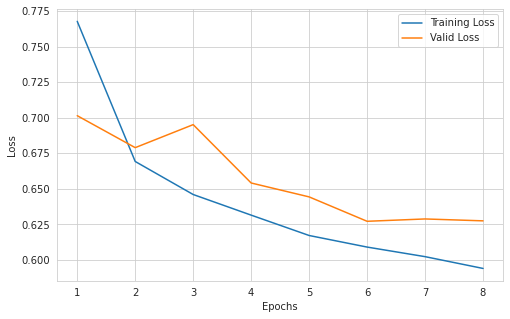

In [21]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.set_style(style="whitegrid")
sns.lineplot(range(1, len(total_train_loss)+1), total_train_loss, label="Training Loss")
sns.lineplot(range(1, len(total_train_loss)+1), total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Save Model

In [22]:
torch.save(model.state_dict(), 'fasterrcnn_best_resnet50.pth')